# Analysis of an RRi series registered during REST condition and RECOVERY from maximal effort exercise

In [1]:
import matplotlib.pyplot as plt
from hrv.filters import quotient
from hrv.io import read_from_text


plt.rcParams['figure.figsize'] = (10, 6)

## Reading the RRi file

In [2]:
rri = read_from_text("data/08012805.txt")

## Getting some information about the file

In [3]:
rri.info()

N Points: 2380
Duration: 1269.54s
Interpolated: False
Detrended: False
Memory Usage: 18.59Kb

The RRi series has **2378** values and approximately **12 seconds**.

## Visual Inspection

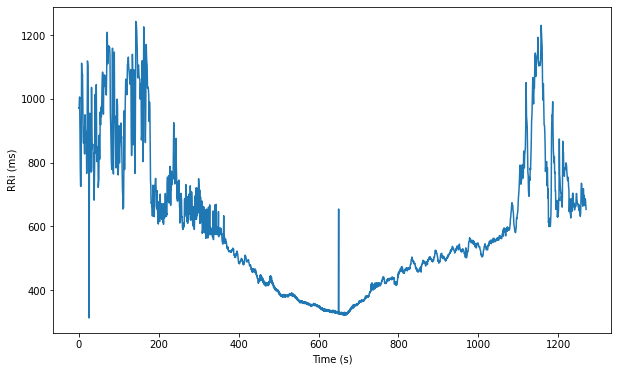

In [4]:
fig, ax = rri.plot()

This is an RRi series recorded during a maximal effort exercise. The first 180 seconds (3 minutes) the subject is resting, after this period the exercise test started and the workload was incremented each minute until the subject's fatigue. Following the exercise, there is a recovery period of approximately 600s (10 minutes).

## Filtering

Looks like there are some noise in the RRi signal. Let's try to filter the time series:

In [5]:
from hrv.filters import quotient, moving_median

### [Quotient Filter](https://www.semanticscholar.org/paper/Filtering-Poincar%C3%A9-plots-Piskorski-Guzik/691f29825db1347f59399dcb66e8f776d79cb4e2)

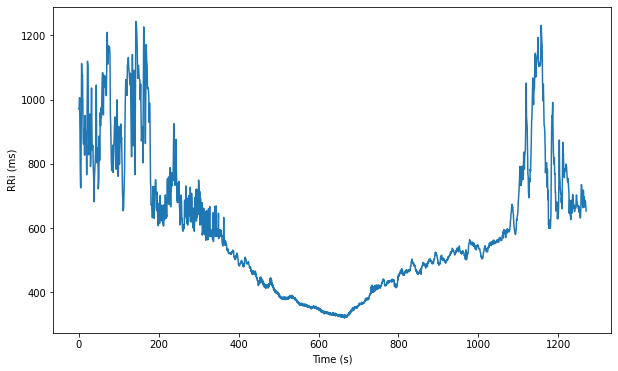

In [6]:
fq_rri = quotient(rri)
fig, ax = fq_rri.plot()

### Moving Median

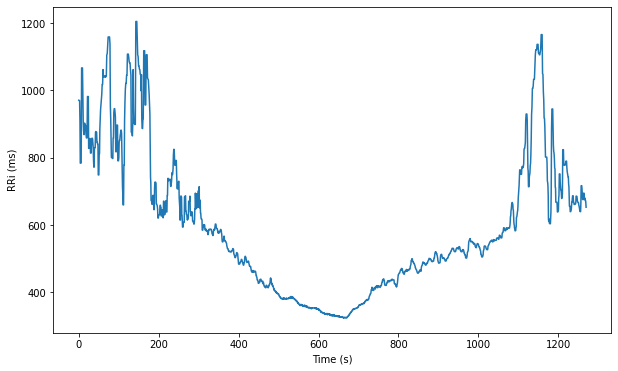

In [7]:
fmm_rri = moving_median(rri, order=5)
fig, ax = fmm_rri.plot()

Both filters removed the spikes, but seems that the quotient filter preserved the signal, only removing the noise, while the `moving_median` filtered the whole tachogram. Let's keep the `quotient` filter results.

### Calculate HRV indices during rest

To extract information about the RRi fluctuations during rest, first we need to slice the time series on the first 180 seconds.

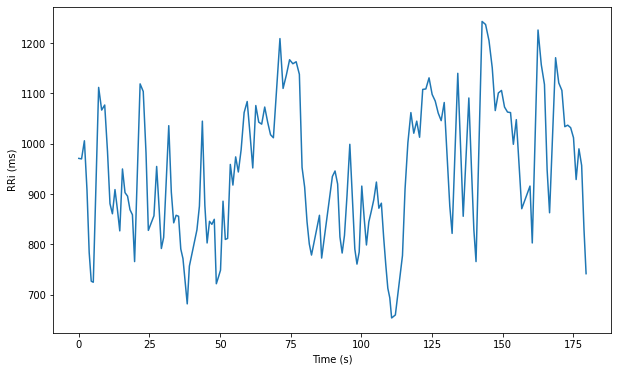

In [8]:
rest_rri = fq_rri.time_range(start=0, end=180)
fig, ax = rest_rri.plot()

### Time Domain and Frequency Domain during Rest

In [9]:
from hrv.classical import frequency_domain, time_domain

rest_time_domain = time_domain(rest_rri)
rest_time_domain

{'rmssd': 108.46944492311053,
 'sdnn': 138.2975645572105,
 'sdsd': 108.78884441364953,
 'nn50': 80,
 'pnn50': 47.90419161676647,
 'mrri': 940.6047904191616,
 'mhr': 65.20538214405263}

Before extracting **Frequency Domain** features lets first remove the slow trend from the RRi signal:

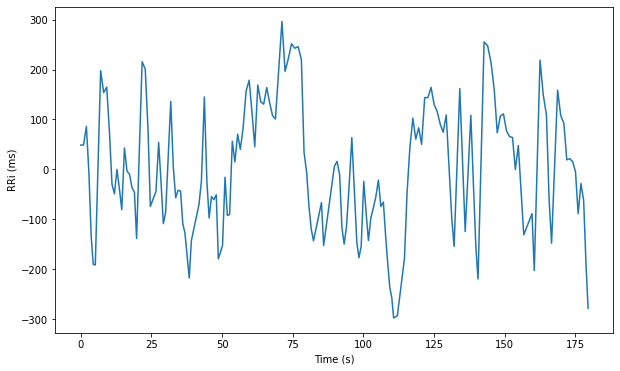

In [10]:
from hrv.detrend import polynomial_detrend

detrended_rest_rri = polynomial_detrend(rest_rri, degree=3)
fig, ax = detrended_rest_rri.plot()

Note how the Y-axis is now centered on zero.

In [11]:
detrended_rest_rri.info()

N Points: 167
Duration: 179.47s
Interpolated: False
Detrended: True
Memory Usage: 1.30Kb

Once our rest signal has only 167 points, lets reduce the segment size and the overlap size of Welch's method to 64 and 32, respectively.

In [12]:
rest_freq_domain = frequency_domain(
    detrended_rest_rri,
    method="welch",
    nperseg=64,
    noverlap=32,
    interp_method="cubic",
    window="hanning",
    fs=4.0
)

rest_freq_domain

{'total_power': 6666.966107339158,
 'vlf': 0.0,
 'lf': 4489.7018504725565,
 'hf': 2177.264256866602,
 'lf_hf': 2.0620840287590476,
 'lfnu': 67.34250299443076,
 'hfnu': 32.65749700556925}

## Comparing the HRV during Rest and at the last three minutes of Recovery

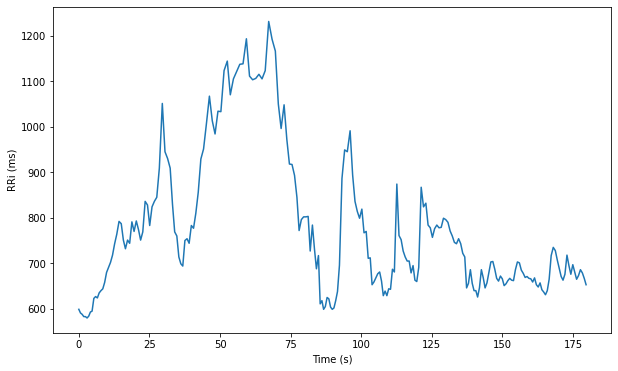

In [13]:
recovery_rri = rri.time_range(start=rri.time[-1] - 180, end=rri.time[-1]).reset_time()
fig, ax = recovery_rri.plot()

In [14]:
recovery_rri.info()

N Points: 236
Duration: 179.61s
Interpolated: False
Detrended: False
Memory Usage: 1.84Kb

### Time Domain and Frequency Domain during Rest

In [15]:
recovery_time_domain = time_domain(recovery_rri)
recovery_time_domain

{'rmssd': 40.601016652190985,
 'sdnn': 147.01795331586942,
 'sdsd': 40.687026822611884,
 'nn50': 39,
 'pnn50': 16.52542372881356,
 'mrri': 763.5805084745763,
 'mhr': 81.04523247544932}

In [16]:
detrended_recovery_rri = polynomial_detrend(recovery_rri, degree=3)

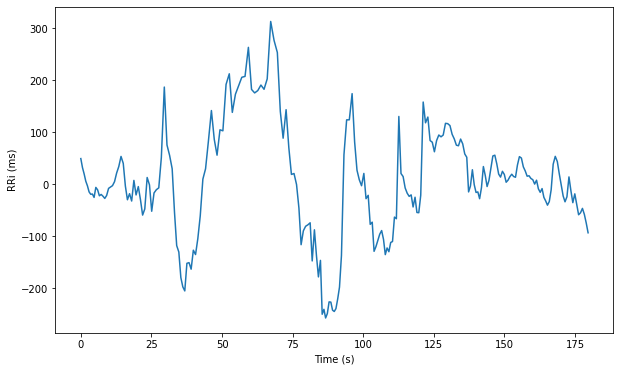

In [17]:
fig, ax = detrended_recovery_rri.plot()

In [18]:
recovery_freq_domain = frequency_domain(
    detrended_recovery_rri,
    method="welch",
    nperseg=64,
    noverlap=32,
    interp_method="cubic",
    window="hanning",
    fs=4.0
)

recovery_freq_domain

{'total_power': 3254.840133817981,
 'vlf': 0.0,
 'lf': 2889.6517734270415,
 'hf': 365.18836039093964,
 'lf_hf': 7.912770742018244,
 'lfnu': 88.78014448093438,
 'hfnu': 11.219855519065622}

In [19]:
def compare_indices(ax, cond_1, cond_2, index_name, title, y_label):
    ax.bar([0, 1], [cond_1[index_name], cond_2[index_name]], color=["b", "r"])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Rest", "Recovery"])
    ax.set(ylabel=y_label)
    ax.set(title=title)

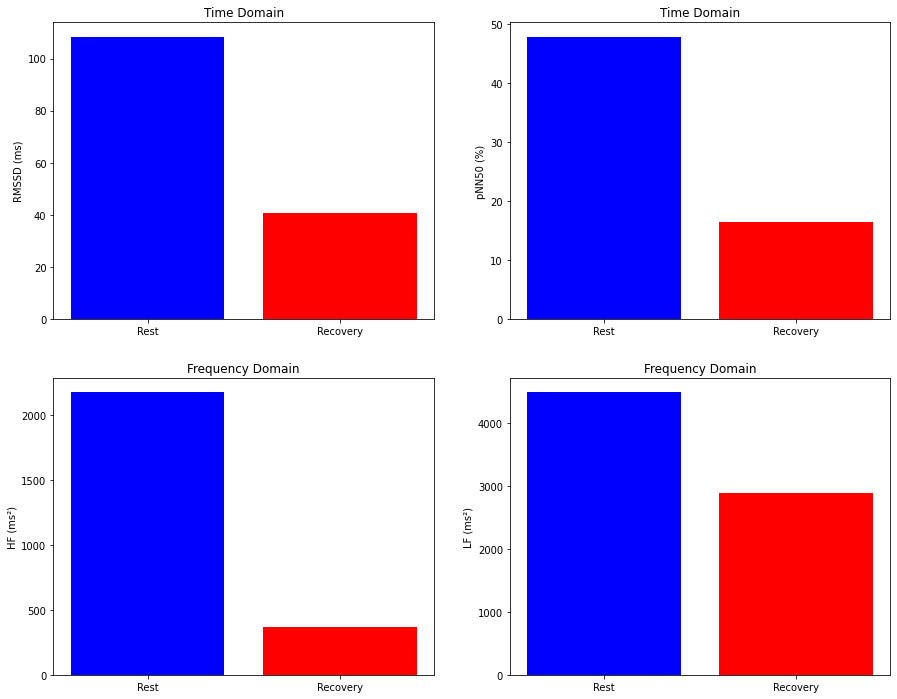

In [20]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 12)

compare_indices(
    ax[0][0],
    rest_time_domain,
    recovery_time_domain,
    "rmssd",
    title="Time Domain",
    y_label="RMSSD (ms)"
)
compare_indices(
    ax[0][1],
    rest_time_domain,
    recovery_time_domain,
    "pnn50",
    title="Time Domain",
    y_label="pNN50 (%)"
)

compare_indices(
    ax[1][0],
    rest_freq_domain,
    recovery_freq_domain,
    "hf",
    title="Frequency Domain",
    y_label="HF (ms²)"
)
compare_indices(
    ax[1][1],
    rest_freq_domain,
    recovery_freq_domain,
    "lf",
    title="Frequency Domain",
    y_label="LF (ms²)"
)

The figure above depicts the comparison between RMSSD, pNN50, HF, and LF extracted on the Rest (blue) and Recovery (red) periods. The reduced values of these indices in the recovery period might indicate that the vagal activity is, at least, partially suppressed after the maximal effort exercise.  

The reduced LF (ms²) measure indicates that the RRi series at the recovery period has fewer overall fluctuations compared to the Rest period.


[Methods of assessment of the post-exercise cardiac autonomic recovery: A methodological review](https://www.sciencedirect.com/science/article/abs/pii/S0167527316331382)

[Absence of parasympathetic reactivation after maximal exercise ](https://pubmed.ncbi.nlm.nih.gov/23383693/)

# Analysis of the dynamics of non-stationary RRi series

One of the reasons for selecting the Rest and the Recovery periods is due to its stationary behavior. Classical HRV indices expect that the statistical properties of the RRi signal are stable as a function of time. Therefore, extracting classical indices (Time and Frequency domain) in non-stationary segments is might bring misleading results.

Let's take a look at the RRi series at the peak of the maximal effort exercise:

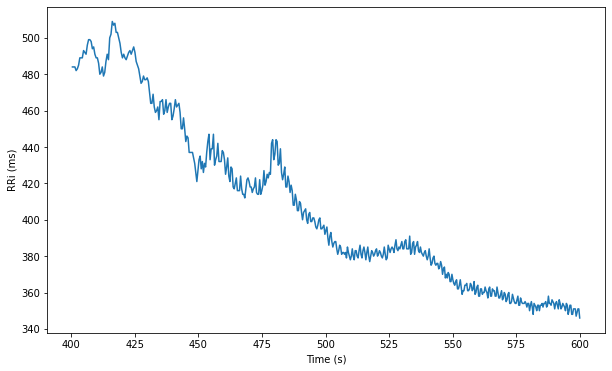

In [21]:
peak_exercise_rri = rri.time_range(start=400, end=600)
fig, ax = peak_exercise_rri.plot()

As shown in the above picture, the RRi series during exercise is non-stationary and for this reason, classical analyses are not recommended.

To overcome the non-stationary behavior and also extract information about the dynamics of the HRV in experiments involving physical exercise, [Tilt maneuver](https://pubmed.ncbi.nlm.nih.gov/2212477/) it is possible to use time-varying method, which consists of splitting the RRi signal into smaller segments (ex: 30s) and calculate the time domain indices of each adjacent segment.


There are also Frequency domain analyses in adjacent smaller segments of the RRi signal like Short Time Fourier Transform,but it is still a work in progress in the `hrv` module.

In [22]:
from hrv.nonstationary import time_varying

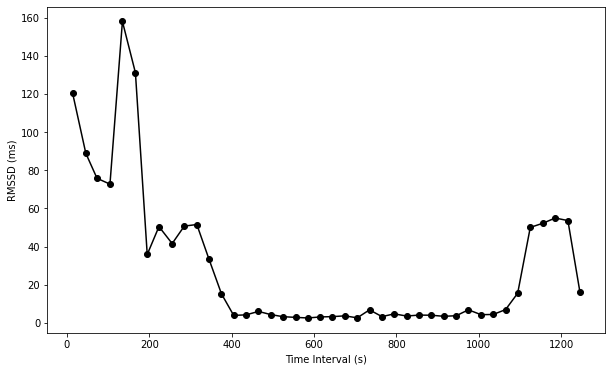

In [23]:
tv_results = time_varying(fq_rri, seg_size=30, overlap=0)

fig, ax = tv_results.plot(marker="o", color="k")